# Motivation

http://edwardlib.org/

https://eng.uber.com/pyro/?imm_mid=0f7b58&cmp=em-prog-na-na-newsltr_20171104

# Einführung

In [1]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas            as pd

from scipy import stats

In [2]:
n_A = n_B = 100000

observations_A = pd.Series(stats.bernoulli.rvs(0.040, size=n_A))
observations_B = pd.Series(stats.bernoulli.rvs(0.042, size=n_B))

In [3]:
sales_A = sum(observations_A)
sales_B = sum(observations_B)

Frage: Welcher Prozess/Welches Modell hat diese Daten generiert.

Erfolg/Misserfolg: Bernoulli-Experiment - Zufallsvariable X binomialverteilt.

Offen: Wie sicher sind wir, das p = 0.014.

* Wähle Trial für p
* Gegebenn dieser Wert für p, simuliere mir Daten dazu.
* Vergleiche die Simulation und die beobachteten Daten.
* Wenn p 'gut', dann merke Dir diesen Wert
* Wiederhole, bis 'ausreichend' viele 'gute' Werte für p gefunden wurden.

# Bootstrapping

In [11]:
import pandas as pd

delta = pd.DataFrame()

In [12]:
t_b = time.process_time()

delta['values'] = [sum(observations_A.sample(n_A, replace=True))/observations_A.size - sum(observations_B.sample(n_B, replace=True))/observations_B.size for _ in range(5000)]    

elapsed_time_b = time.process_time() - t_b

In [13]:
elapsed_time_b/60

1.7088541666666666

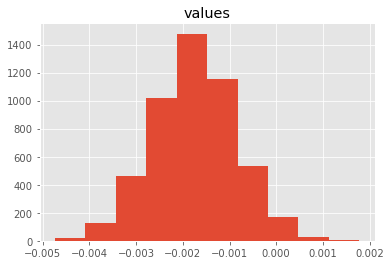

In [14]:
_ = delta.hist()

In [15]:
delta.quantile(q=[0.025, 0.975], axis=0)

,values
0.025,-0.00349
0.975,0.00001


In [44]:
sum(delta.values < 0)/delta.size

array([ 0.9738])

# Probabilistic Modeling

In [16]:
import random

def prior_sampler():
    while True:
        yield random.random() # Zufallszahl zwischen 0 und 1

In [17]:
import numpy as np

def simulate(n, p):
    return np.random.binomial(n,p)

In [18]:
def compare(sim, obs):
    return sim == obs

In [19]:
def abc(data, prior_sampler, simulate, compare):
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p

In [20]:
from functools import partial

posterior_sampler_A = abc(data=sales_A, prior_sampler=prior_sampler(), simulate=partial(simulate, n_A), compare=compare)
posterior_sampler_B = abc(data=sales_B, prior_sampler=prior_sampler(), simulate=partial(simulate, n_B), compare=compare)

In [21]:
import itertools

def take(n, iterable):
    return list(itertools.islice(iterable, n))

In [22]:
t_pm = time.process_time()

samples_A = take(5000, posterior_sampler_A)
samples_B = take(5000, posterior_sampler_B)

elapsed_time_pm = time.process_time() - t_pm

In [23]:
elapsed_time_pm/60

42.106510416666666

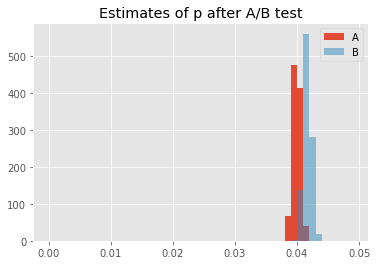

In [24]:
abbins = [i/1000.0 for i in range(50)]
plt.hist(samples_A, bins=abbins, label='A', normed=True)
plt.hist(samples_B, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of p after A/B test')
plt.legend();

In [25]:
b_better = [b > a for a, b in zip(samples_A, samples_B)]
print(sum(b_better)/len(samples_A))

0.977


# Probabilistic Programming

In [4]:
import pymc3 as pm

In [5]:
t_pp = time.process_time()

with pm.Model():
    
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)
    
    delta = pm.Deterministic("delta", p_A - p_B)

    trace = pm.sample(draws=5000, step=pm.Metropolis(), progressbar=True)
    
elapsed_time_pp = time.process_time() - t_pp

100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:11<00:00, 482.56it/s]


In [6]:
elapsed_time_pp/60

0.22317708333333333

In [7]:
p_A_samples   = trace["p_A"]
p_B_samples   = trace["p_B"]
delta_samples = trace["delta"]

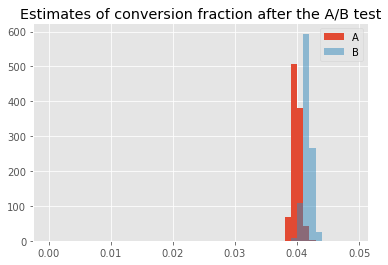

In [8]:
abbins = [i/1000.0 for i in range(50)]
plt.hist(p_A_samples[1000:], bins=abbins, label='A', normed=True)
plt.hist(p_B_samples[1000:], bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of p after A/B test')
plt.legend();

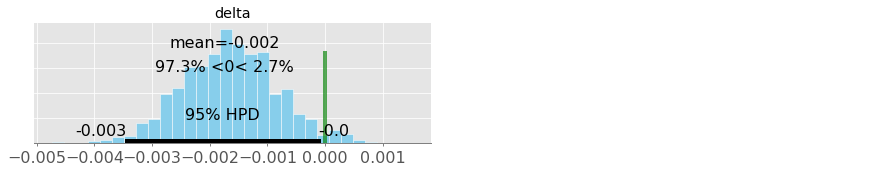

In [9]:
_ = pm.plot_posterior(trace[1000:], varnames=['delta'], ref_val=0, color='#87ceeb')

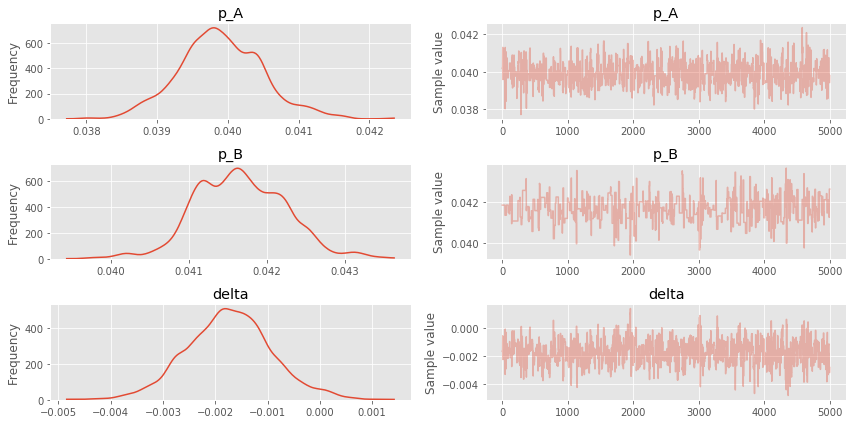

In [10]:
_ = pm.traceplot(trace, grid=True)